<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Цели-проекта" data-toc-modified-id="Цели-проекта-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Цели проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#План-работы" data-toc-modified-id="План-работы-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>План работы</a></span></li></ul></li><li><span><a href="#Загрузка-и-изучение-данных" data-toc-modified-id="Загрузка-и-изучение-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и изучение данных</a></span></li><li><span><a href="#Подготовка-данных-для-моделей" data-toc-modified-id="Подготовка-данных-для-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных для моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></div>

# Матчинг

 ## Описание проекта

В данном проекте необходимо создать такой алгоритм, который для запрашиваемого товара найдет несколько наиболее подходящих вариантов.

### Цели проекта

- разработать алгоритм, который для всех товаров из _validation.csv_ предложит несколько вариантов наиболее похожих товаров из _base.csv_;
- оценить качество алгоритма по метрике _accuracy@5_ .

### Описание данных

- _base.csv_ - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base...) и вектор признаков размерностью 72.
- _train.csv_ - обучающий датасет. Каждая строчка - 1 товар, для которого известен уникальный id (0-query, 1-query, ...), вектор признаков и id товара из _base.csv_, который максимально похож на него (по мнению экспертов).
- _validation.csv_ - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из _base.csv_.
- _validation_answer.csv_ - правильные ответы к _validation.csv_.

### План работы

1. Загрузка и изучение данных 
2. Подготовка данных
3. Обучение моделей
      - обучение FAISS
      - обучение CatBoostClassifier
4. Измерение качества модели
5. Общий вывод

 ## Загрузка и изучение данных 

In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import faiss
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

'base'

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


'train'

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


'valid'

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


'valid_answ'

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [3]:
#размер выборок
print(df_base.shape)
print(df_train.shape)
print(df_valid.shape)
print(df_valid_answ.shape)

(2918139, 72)
(100000, 73)
(100000, 72)
(100000, 1)


In [4]:
#вывод основной информации о датафреймах
print('base', df_base.info())
print('train', df_train.info())
print('valid', df_valid.info())
print('valid_answ', df_valid_answ.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [5]:
#проверим данные на пропуски
print(df_base.isna().sum())
print(df_train.isna().sum())
print(df_valid.isna().sum())
print(df_valid_answ.isna().sum())

0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64
0         0
1         0
2         0
3         0
4         0
         ..
68        0
69        0
70        0
71        0
Target    0
Length: 73, dtype: int64
0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64
Expected    0
dtype: int64


In [6]:
#проверим данные на явные дубликаты
print(df_base.duplicated().sum())
print(df_train.duplicated().sum())
print(df_valid.duplicated().sum())
print(df_valid_answ.duplicated().sum())

0
0
0
8498


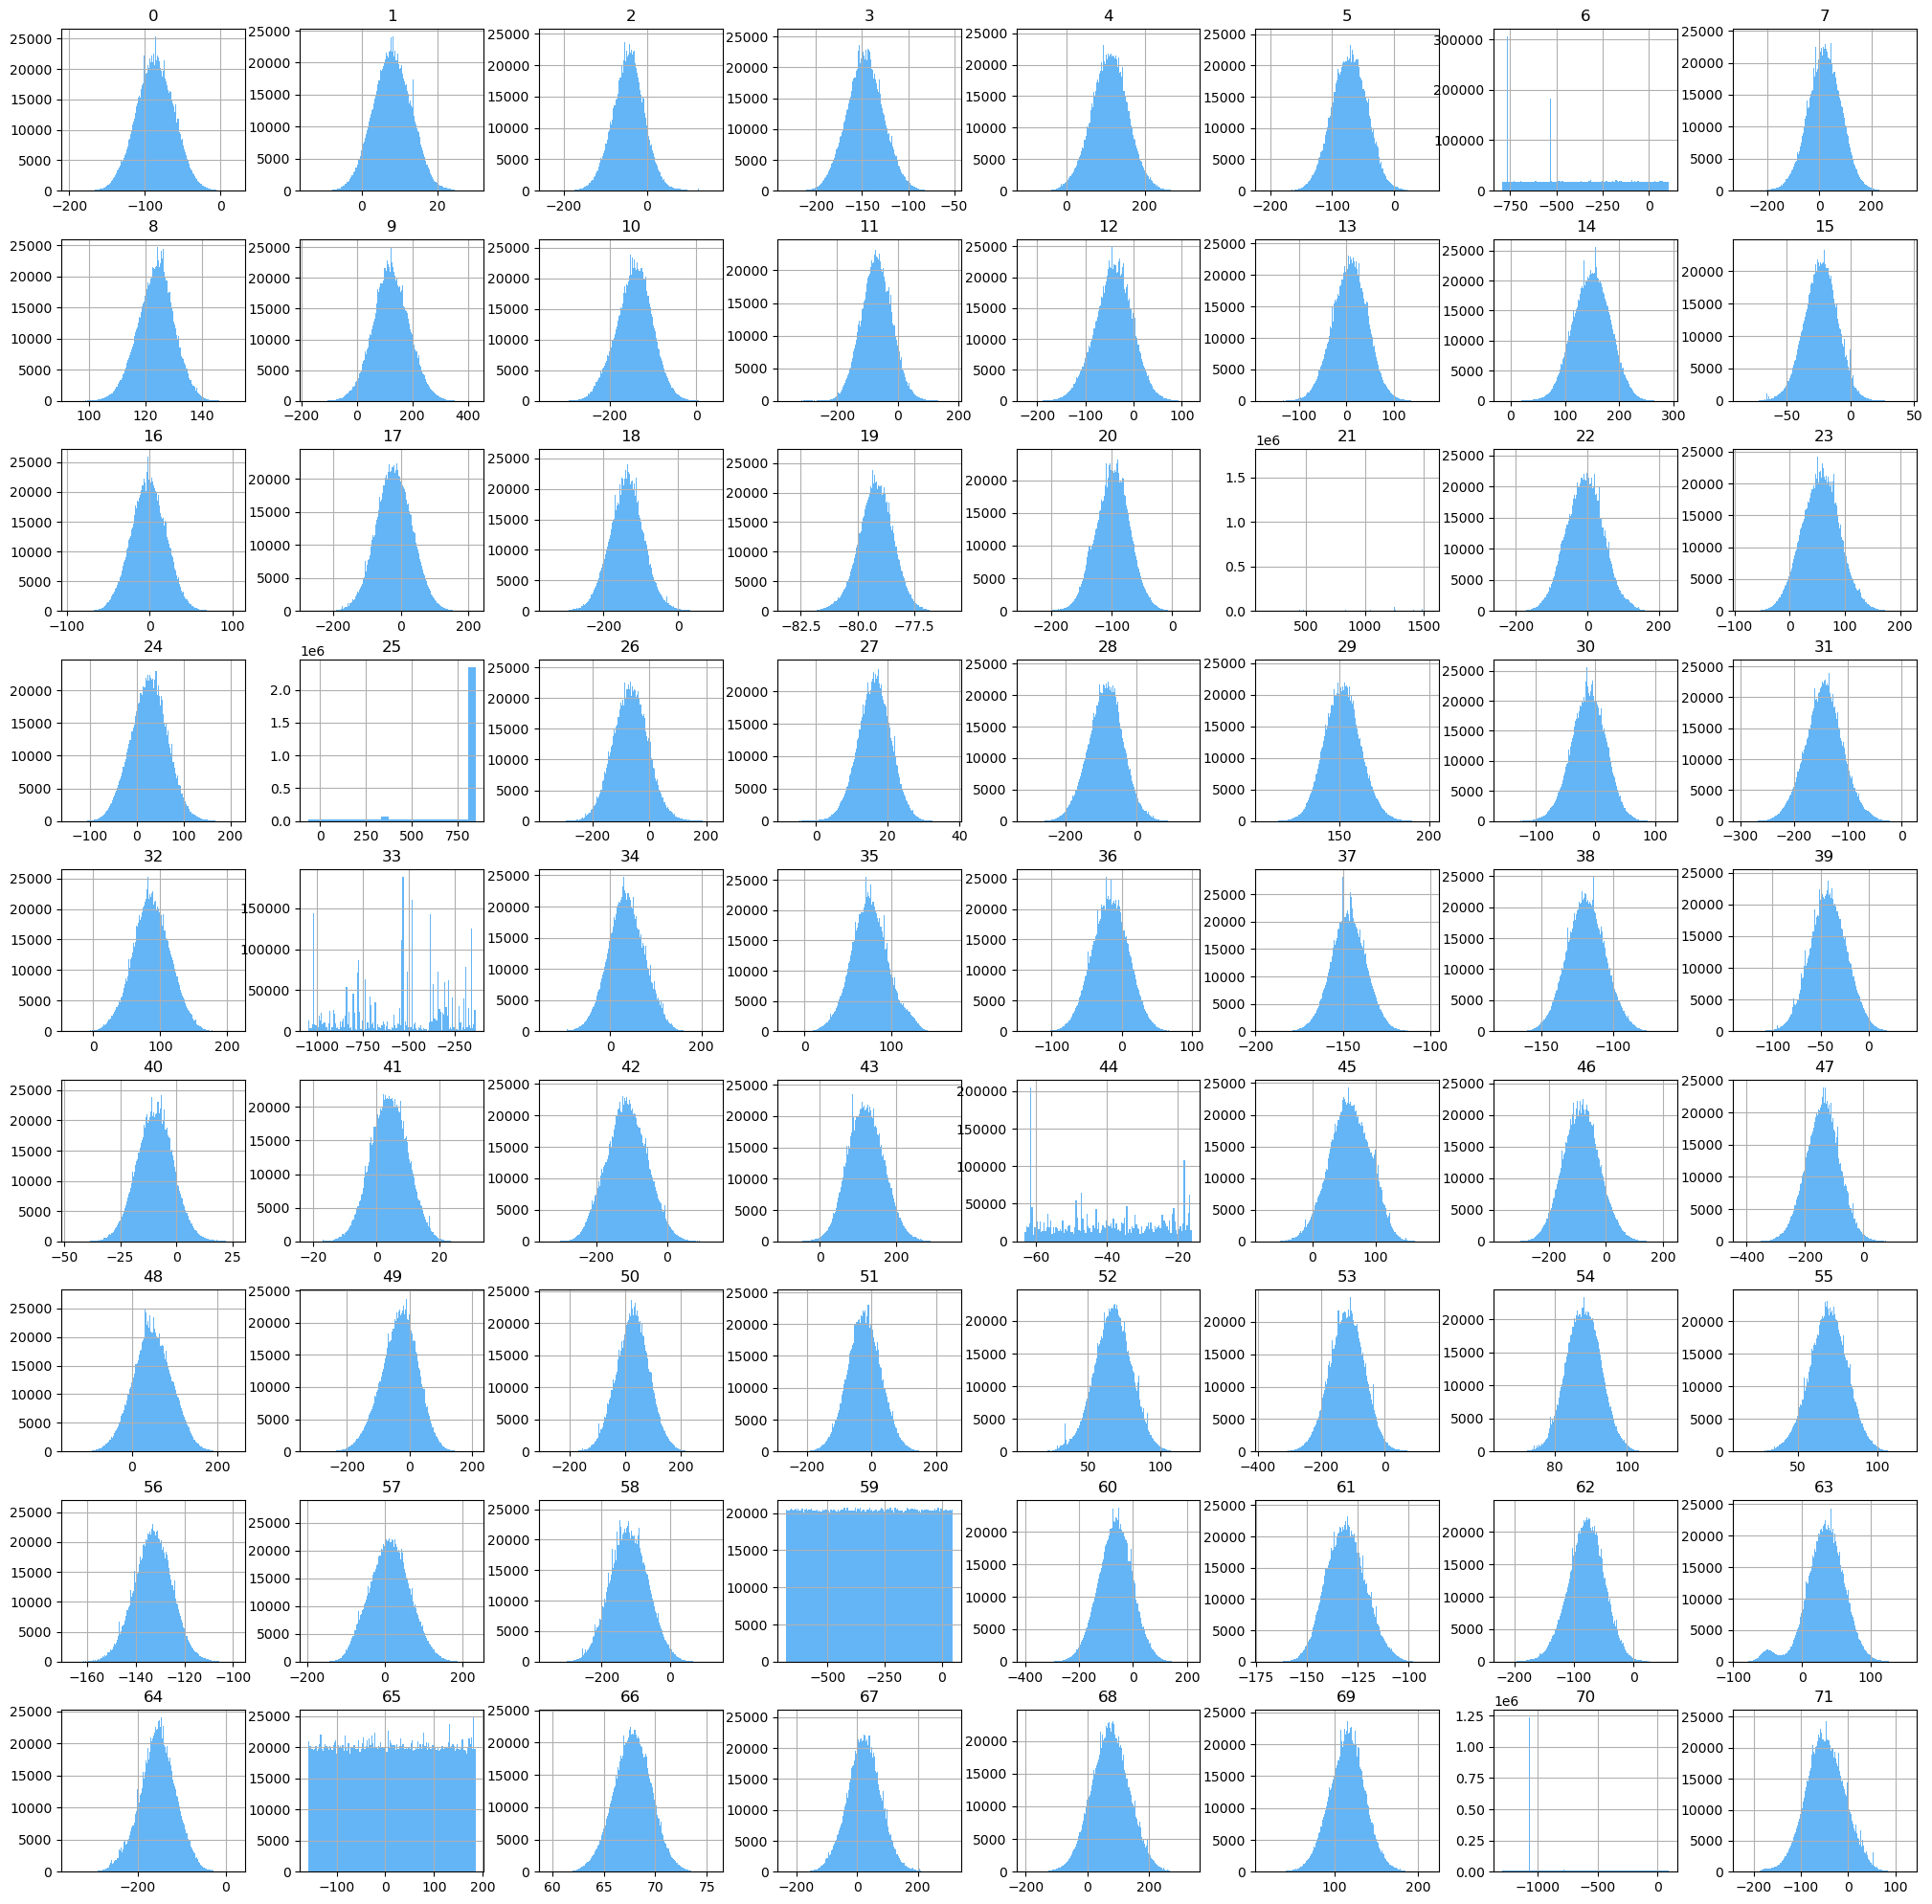

In [7]:
#построим гистограммы
df_base.hist(figsize=(25,25), color='#64B5F6', bins='auto')
plt.show()

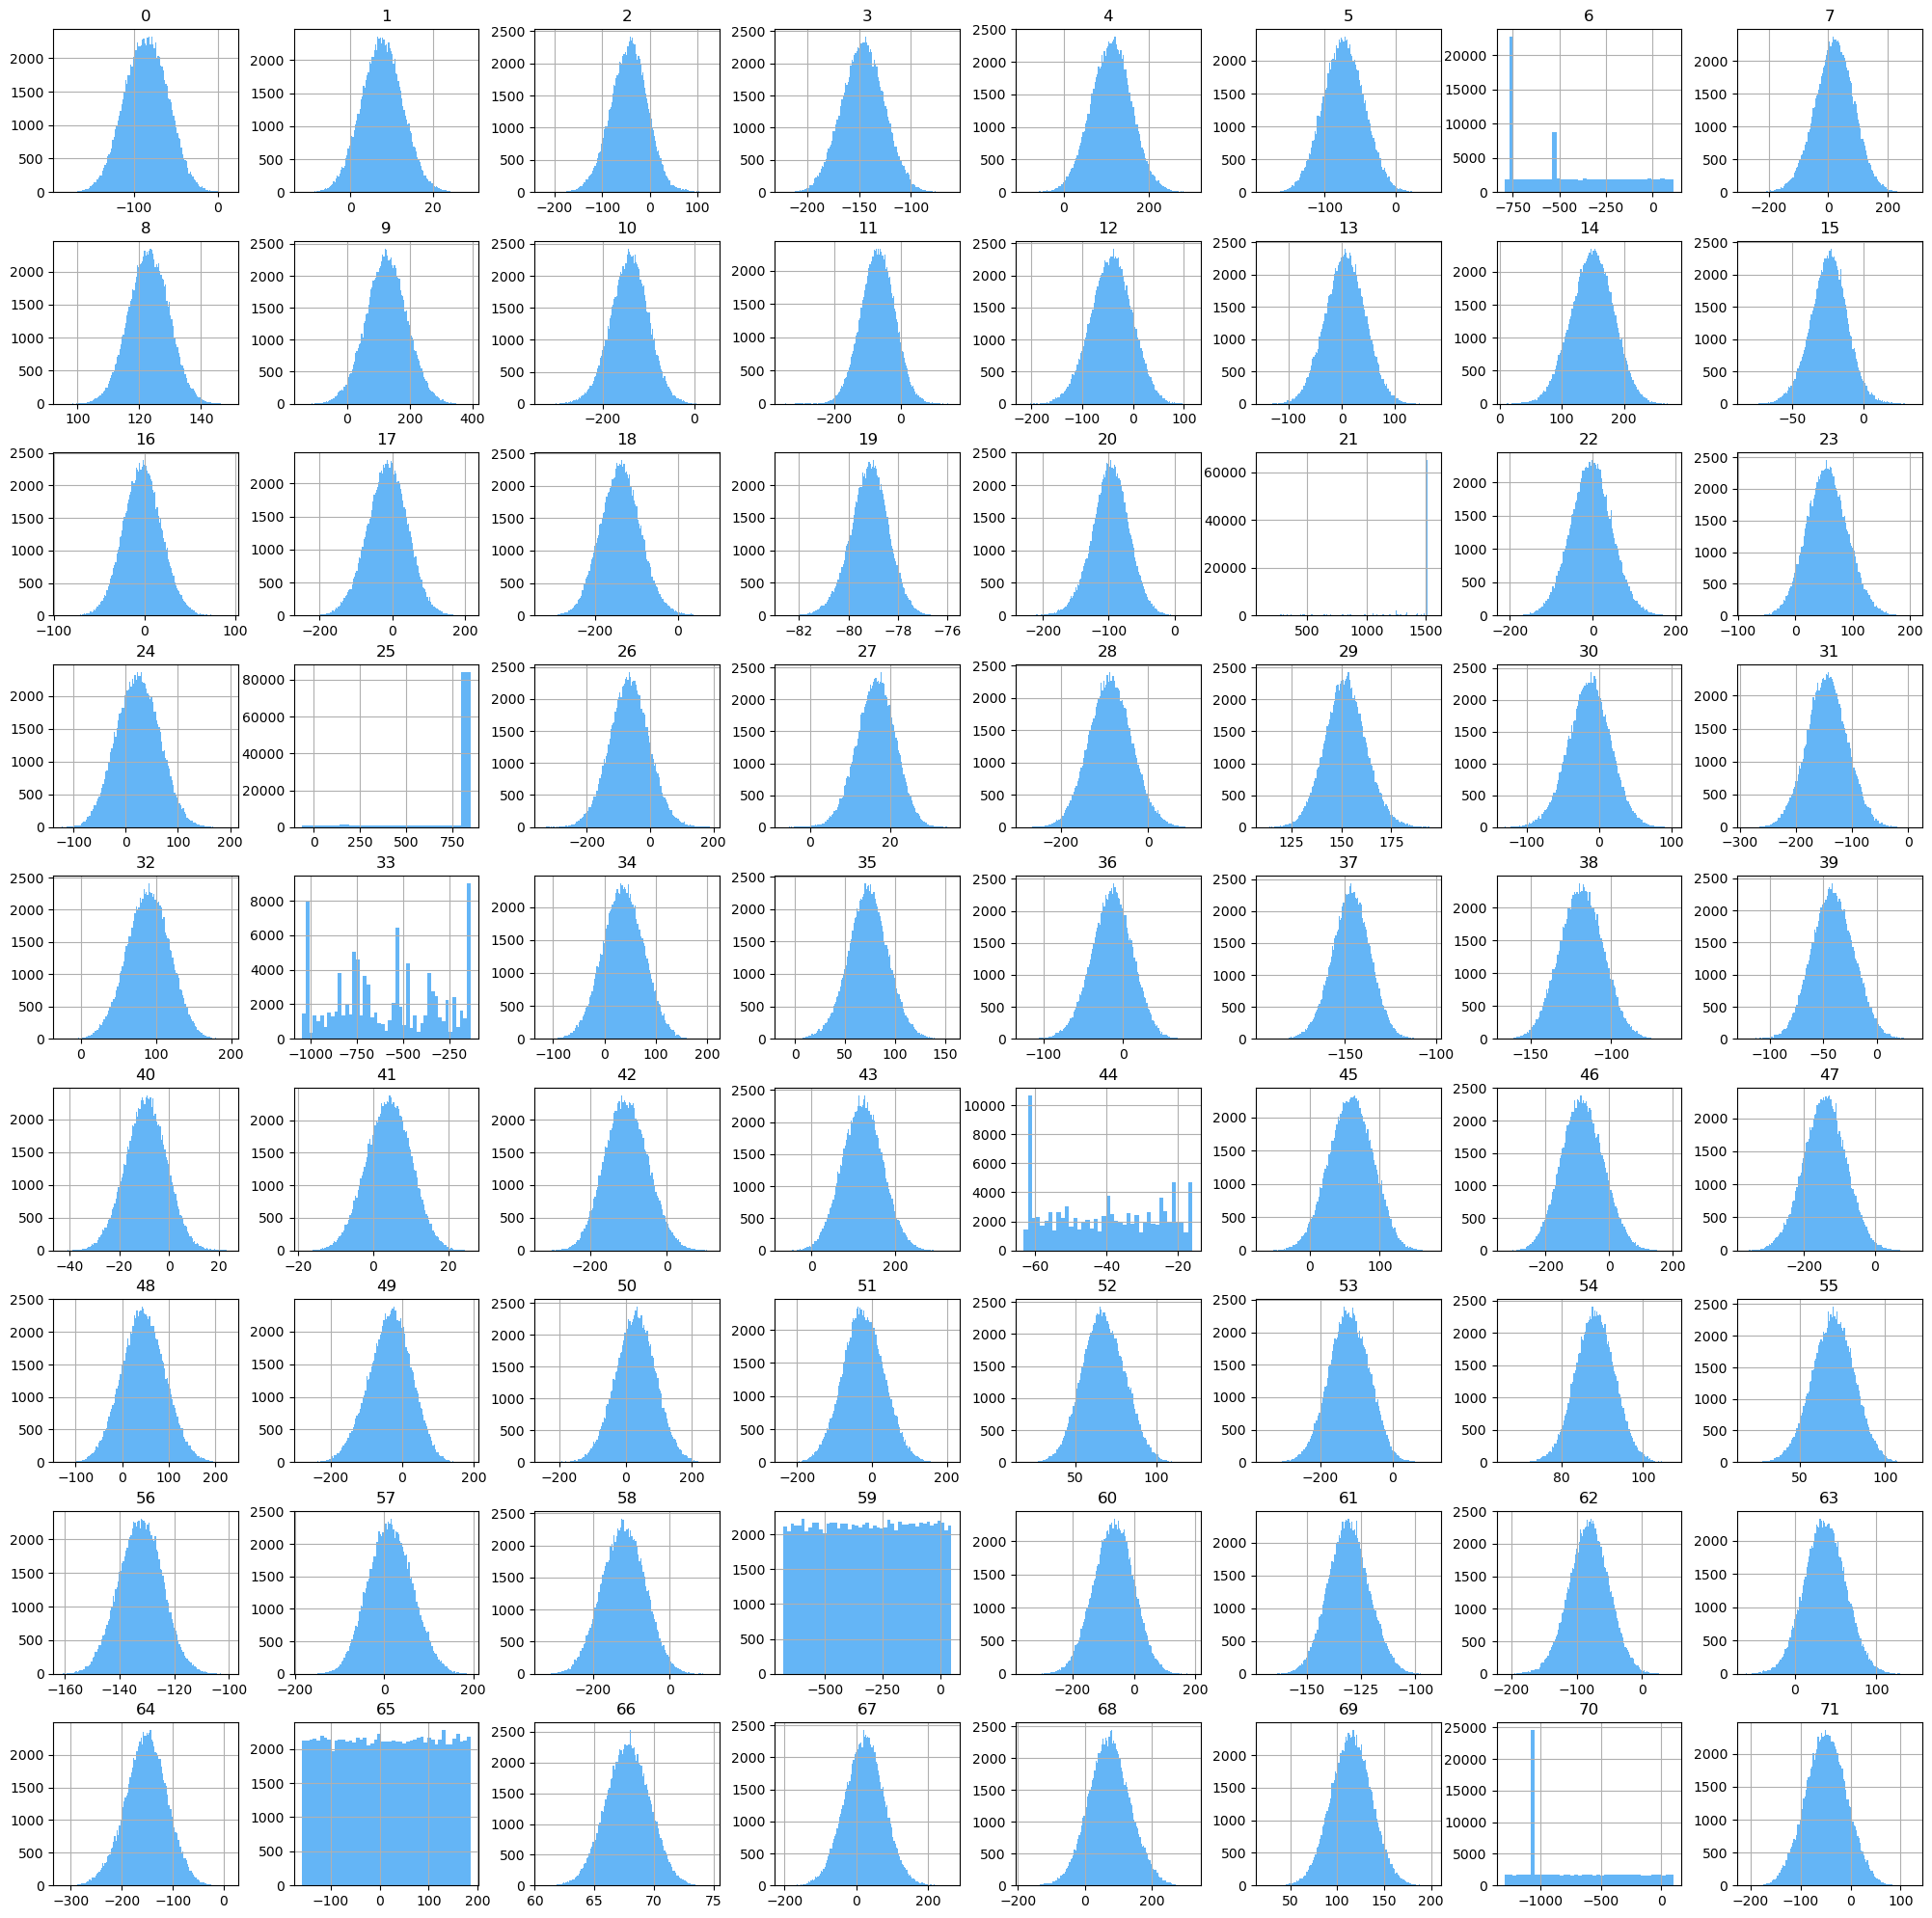

In [8]:
#построим гистограммы
df_train.hist(figsize=(25,25), color='#64B5F6', bins='auto')
plt.show()

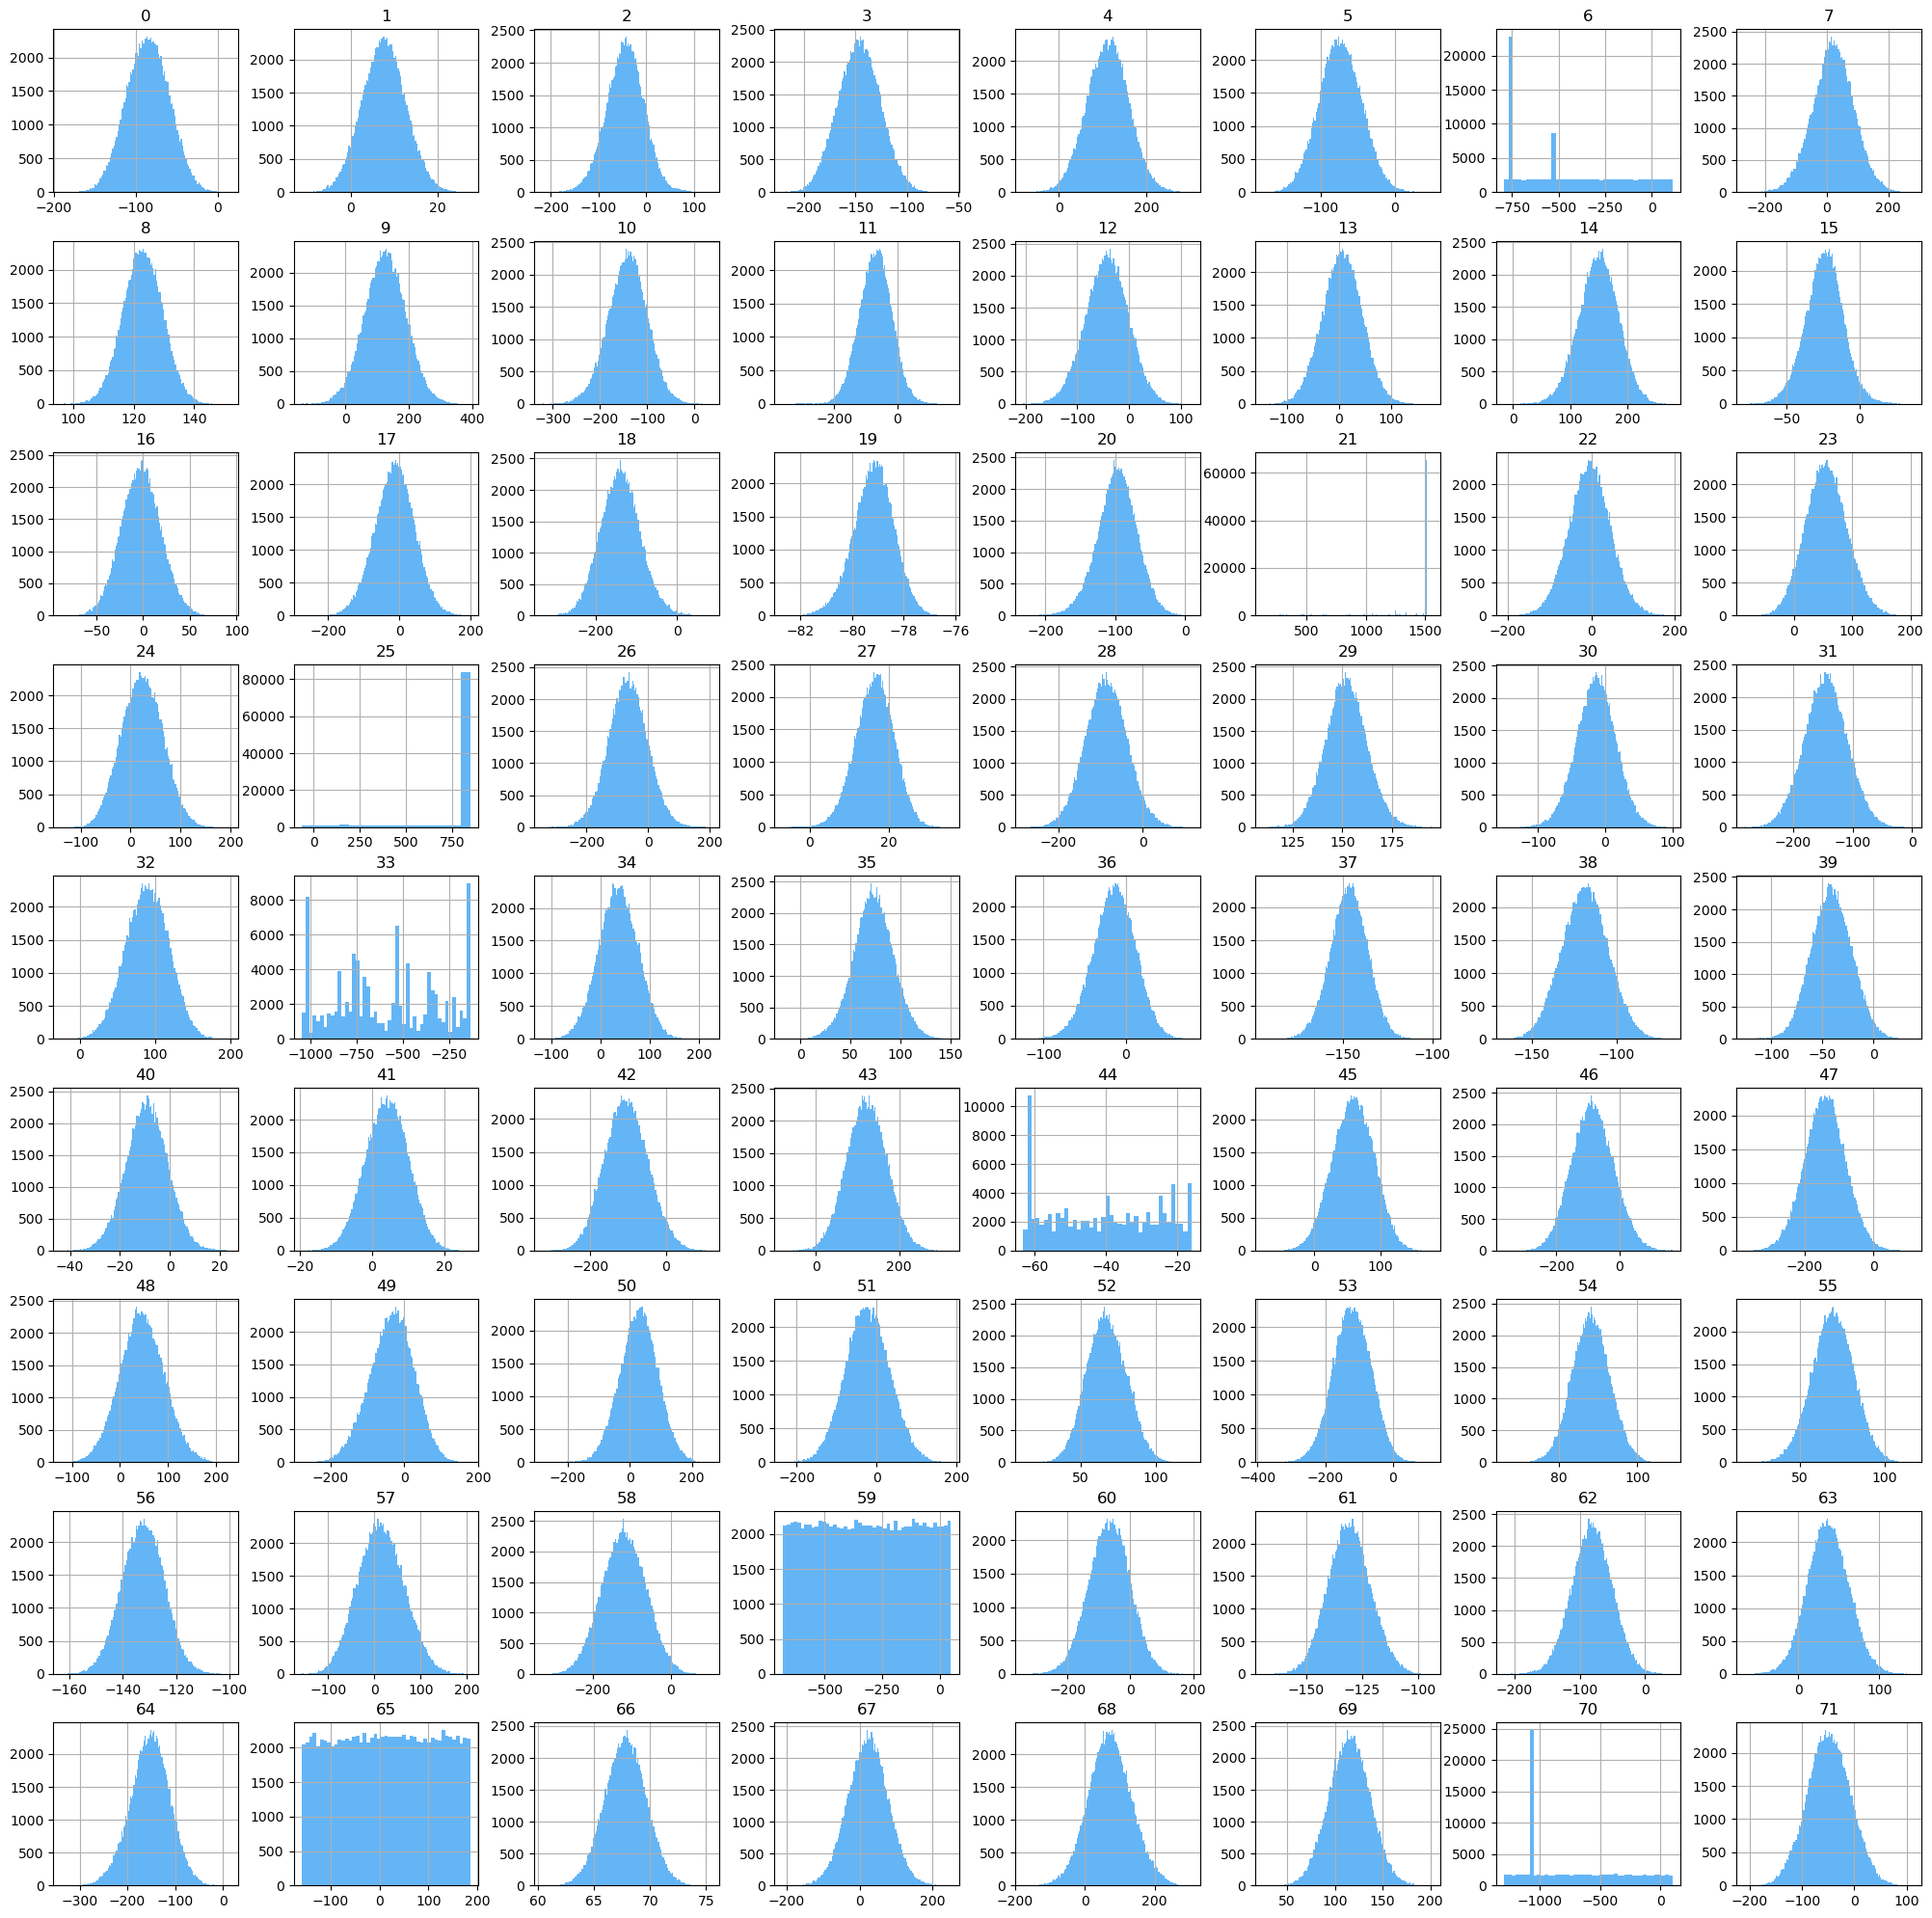

In [9]:
#построим гистограммы
df_valid.hist(figsize=(25,25), color='#64B5F6', bins='auto')
plt.show()

В данном разделе были загружены и изучены данные.
В базовом датасете _2918139_ строк, тогда как в обучающем, валидационном и проверочном по _100000_ строк. Размерность обучающего датасета больше на 1 столбец, так как в нем находится целевой признак `Target`, далее он будет выделен в отдельную переменную. Пропусков в данных нет, дубликатов тоже. Дубликаты из ответов могут быть, так как повторяться ответы могут. Удалять их не нужно. 
Далее были построены гистограммы для всех столбцов базового, обучающего и валидационного датасета. Все столбцы распределены нормально, кроме столбцов под номерами: `6`, `21`, `25`, `33`, `44`, `59`, `65`, `70`. Пока их оставим для моделей.

## Подготовка данных для моделей

In [20]:
#сформируем признаки и целевой признак для обучающего и валидационного датасета
target_train = df_train['Target']
features_train = df_train.drop('Target', axis=1)


display(features_train.head())
display(target_train.head())

features_valid = df_valid
target_valid = df_valid_answ['Expected']

display(features_valid.head())
display(target_valid.head())

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,-68.770600,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351


Id
0-query     675816-base
1-query     366656-base
2-query    1447819-base
3-query    1472602-base
4-query     717819-base
Name: Target, dtype: object

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


Id
100000-query    2676668-base
100001-query      91606-base
100002-query     472256-base
100003-query    3168654-base
100004-query      75484-base
Name: Expected, dtype: object

In [21]:
#нормализуем признаки 

scaler = StandardScaler()
base_scaled = scaler.fit_transform(df_base)

features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)

#display(base_scaled.head())
#display(features_train_scaled.head())
#display(features_valid_scaled.head())

In [24]:
#пронумеруем индексы из базы товаров
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
base_index

{0: '0-base',
 1: '1-base',
 2: '2-base',
 3: '3-base',
 4: '4-base',
 5: '5-base',
 6: '6-base',
 7: '7-base',
 8: '8-base',
 9: '9-base',
 10: '10-base',
 11: '11-base',
 12: '12-base',
 13: '13-base',
 14: '14-base',
 15: '15-base',
 16: '16-base',
 17: '17-base',
 18: '18-base',
 19: '19-base',
 20: '20-base',
 21: '21-base',
 22: '22-base',
 23: '23-base',
 24: '24-base',
 25: '25-base',
 26: '26-base',
 27: '27-base',
 28: '28-base',
 29: '29-base',
 30: '30-base',
 31: '31-base',
 32: '32-base',
 33: '33-base',
 34: '34-base',
 35: '35-base',
 36: '36-base',
 37: '37-base',
 38: '38-base',
 39: '39-base',
 40: '40-base',
 41: '41-base',
 42: '42-base',
 43: '43-base',
 44: '44-base',
 45: '45-base',
 46: '46-base',
 47: '47-base',
 48: '48-base',
 49: '49-base',
 50: '50-base',
 51: '51-base',
 52: '52-base',
 53: '53-base',
 54: '54-base',
 55: '55-base',
 56: '56-base',
 57: '57-base',
 58: '58-base',
 59: '59-base',
 60: '60-base',
 61: '61-base',
 62: '62-base',
 63: '63-bas

In [25]:
#удалим лишние переменные
del df_base
del df_train
del df_valid

## Обучение моделей

In [22]:
#создадим инвертированный индекс FAISS
dims = base_scaled.shape[1]
n_cells = 1000 #количество кластеров с центроидами 

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [23]:
#обучим FAISS
idx_l2.train(base_scaled[:50000, :])
idx_l2.add(base_scaled)
idx_l2.nprobe = 16 #количество кластеров с центроидами для поиска соседей

In [40]:
#найдем соседей в train
vecs, idx = idx_l2.search(features_train_scaled, 5)

In [41]:
#рассчитаем accuracy для соседей на train
acc = 0
for target, el in zip(target_train.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

64.348


In [42]:
#найдем соседей в valid
vecs_v, idx_v = idx_l2.search(features_valid_scaled, 5)

In [43]:
#рассчитаем accuracy для соседей на valid
acc = 0
for target, el in zip(target_valid.values.tolist(), idx_v.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

64.17


На чистом FAISS были получены следующие результаты по accuracy:

| Количество соседей |train | valid |
| :----------------: | :-----: |:-----:|
| 5 | 64.348 |64.17|
| 10 | 67.898 |67.747|
| 30 | 72.227 |72.192|
| 50 | 74.012 |73.962|

In [45]:
#сгенерируем бинарный целевой признак для CatBoost
k = 10  #кол-во соседей

target_train_binary = []

for i in range(len(features_train_scaled)):
    query_vector = features_train_scaled[i]
    _, indices = idx_l2.search(query_vector.reshape(1, -1), k)
    neighbors_targets = [base_index[j] for j in indices[0]]  
    target = target_train[i]
    binary_values = [1 if j == target else 0 for j in neighbors_targets]
    target_train_binary.extend(binary_values)

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [46]:
#проверим количество значений
len(target_train_binary)

1000000

In [48]:
#продублируем вектора запросов на 10 соседей для CatBoost
features_train_duplicated = np.repeat(features_train_scaled, 10, axis=0)
#проверим количество значений
len(features_train_duplicated)

1000000

In [49]:
#обучим CatBoostClassifier
model = CatBoostClassifier(iterations=1000, depth=8, learning_rate=0.1, random_state=42,\
                           eval_metric='Accuracy', auto_class_weights='Balanced', verbose=False)
model.fit(features_train_duplicated, target_train_binary)

0:	learn: 0.5509656	total: 476ms	remaining: 7m 55s
1:	learn: 0.5558927	total: 784ms	remaining: 6m 31s
2:	learn: 0.5596668	total: 1.11s	remaining: 6m 9s
3:	learn: 0.5613352	total: 1.41s	remaining: 5m 51s
4:	learn: 0.5609172	total: 1.7s	remaining: 5m 37s
5:	learn: 0.5607751	total: 2.02s	remaining: 5m 34s
6:	learn: 0.5605448	total: 2.34s	remaining: 5m 32s
7:	learn: 0.5603737	total: 2.66s	remaining: 5m 30s
8:	learn: 0.5601261	total: 3.03s	remaining: 5m 33s
9:	learn: 0.5606605	total: 3.34s	remaining: 5m 31s
10:	learn: 0.5608796	total: 3.76s	remaining: 5m 38s
11:	learn: 0.5612549	total: 4.09s	remaining: 5m 36s
12:	learn: 0.5626464	total: 4.4s	remaining: 5m 34s
13:	learn: 0.5629273	total: 4.73s	remaining: 5m 33s
14:	learn: 0.5630842	total: 5.05s	remaining: 5m 31s
15:	learn: 0.5633731	total: 5.38s	remaining: 5m 30s
16:	learn: 0.5635748	total: 5.75s	remaining: 5m 32s
17:	learn: 0.5641819	total: 6.07s	remaining: 5m 31s
18:	learn: 0.5646169	total: 6.41s	remaining: 5m 31s
19:	learn: 0.5652134	tota

<div class="alert alert-info">
<h2> Комментарии: <a class="tocSkip"> </h2>

Делала с pipeline и gridsearch, но пока для ускорения работы ноутбука и проверки оставила так.
    Здесь accuracy = 63.86
</div>

In [68]:
#получаем индексы ближайших 10 соседей для каждого наблюдения
_, indices = idx_l2.search(features_valid_scaled, k=10)

#повторяем каждую строку в features_valid_scaled 10 раз
features_valid_duplicated = np.repeat(features_valid_scaled, 10, axis=0)

#получаем вероятности предсказания класса 1 для повторенных строк
predictions_prob = model.predict_proba(features_valid_duplicated)[:, 1]

#создаем список верных меток из target_valid
true_labels = target_valid.values

#инициализируем список для хранения метрик accuracy@5
accuracy_at_5_list = []

#проходим по индексам ближайших соседей и вероятностям
for i, (neighbor_indices, pred) in enumerate(zip(indices, predictions_prob)):
    #получаем метки соседей для текущей группы из 10 соседей
    neighbors_targets = [base_index[j] for j in neighbor_indices]
    
    #получаем метки верхних 5 предсказанных классов
    top5_indices = np.argsort(-pred)[:5]
    top5_labels = [1 if true_labels[idx] in neighbors_targets else 0 for idx in top5_indices]

    #рассчитываем accuracy@5
    accuracy_at_5 = sum(top5_labels) / 5
    
    accuracy_at_5_list.append(accuracy_at_5)  #добавляем в список

#рассчитываем среднюю метрику accuracy@5
average_accuracy_at_5 = sum(accuracy_at_5_list) / len(accuracy_at_5_list)

print("Average Accuracy@5:", average_accuracy_at_5)

Average Accuracy@5: 2e-06


In [69]:
neighbors_targets

['4678196-base',
 '3842322-base',
 '354733-base',
 '2385617-base',
 '2975569-base',
 '2503531-base',
 '58990-base',
 '1351184-base',
 '84881-base',
 '337547-base']

In [70]:
#получаем индексы ближайших 10 соседей для каждого наблюдения
_, indices = idx_l2.search(features_valid_scaled, k=10)

#получаем расстояния до ближайших 10 соседей для каждого наблюдения
_, distances = idx_l2.search(features_valid_scaled, k=10)

#повторяем каждую строку в features_valid_scaled 10 раз
features_valid_duplicated = np.repeat(features_valid_scaled, 10, axis=0)

#получаем вероятности предсказания класса 1 для повторенных строк
predictions_prob = model.predict_proba(features_valid_duplicated)[:, 1]

#создаем список верных меток из target_valid
true_labels = target_valid.values

#инициализируем список для хранения метрик accuracy@5
accuracy_at_5_list = []

#проходим по индексам ближайших соседей и вероятностям
for i, (neighbor_indices, neighbor_distances, pred) in enumerate(zip(indices, distances, predictions_prob)):
    #сортируем соседей по расстоянию в порядке возрастания
    sorted_neighbors = [neighbor_indices[j] for j in np.argsort(neighbor_distances)]
    
    #получаем метки верхних 5 предсказанных классов
    top5_indices = np.argsort(-pred)[:5]
    top5_labels = [1 if true_labels[idx] in sorted_neighbors[:10] else 0 for idx in top5_indices]

    #рассчитываем accuracy@5
    accuracy_at_5 = sum(top5_labels) / 5
    
    accuracy_at_5_list.append(accuracy_at_5)  #добавляем в список

#рассчитываем среднюю метрику accuracy@5
average_accuracy_at_5 = sum(accuracy_at_5_list) / len(accuracy_at_5_list)

print("Average Accuracy@5:", average_accuracy_at_5)

Average Accuracy@5: 0.0


<div class="alert alert-info">
<h2> Комментарии: <a class="tocSkip"> </h2>

Я не очень понимаю, правильно ли предсказываю и ранжирую. Нужно ли тут дублирование строк? Вроде на каждый запрос должен быть свой ответ. Нужно ли добавлять вектора из базы в фичи? И как это удобнее делать? Я пробовала наращивать и обучающий набор, и валидирующий, но у меня комп сдыхал каждый раз. Можно ли модифицировать мою данную часть работы, чтобы получить верный результат? И еще: может сортировать по расстоянию? Отсортировать 5 ближайших по расстоянию соседей, и посмотреть: совпадет или нет? Тогда нужно и обучать с расстояниями, да? Возможно, я уже не вижу чего-то очевидного. Очень много часов просидела и не достигла нужного результата.
</div>

<div class="alert alert-info">
<h2> Комментарии: <a class="tocSkip"> </h2>

Второй файл, названный **matching_draft**, там все попытки наращивать датасеты для фичей, но я запуталась в features_valid там окончательно.

</div>